Mounted at /content/drive
Initial DataFrame shape: (5000, 10)
Columns before cleaning: ['Price', 'Bedrooms', 'Bathrooms', 'SqFt', 'City', 'Province', 'Year_Built', 'Type', 'Garage', 'Lot_Area']
    Price  Bedrooms  Bathrooms  SqFt       City Province  Year_Built  \
0  873630         5          2  1010   Montreal       BC        1960   
1  377869         2          2  3591    Toronto       ON        1958   
2  128030         4          1  3823   Montreal       ON        2002   
3  117730         3          2  2848   Montreal       QC        1975   
4  292476         4          1  3659  Vancouver       QC        2018   

        Type  Garage  Lot_Area  
0      Condo       1      7919  
1      House       1      7304  
2      House       0      4548  
3  Apartment       1      3374  
4      Condo       1      1281  
Price column type: int64


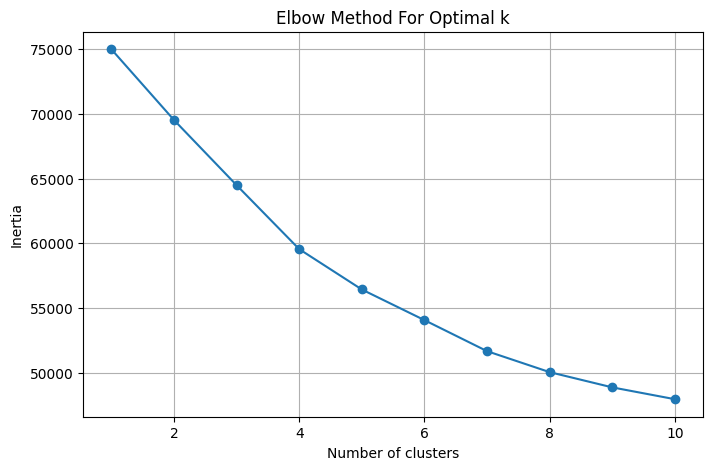

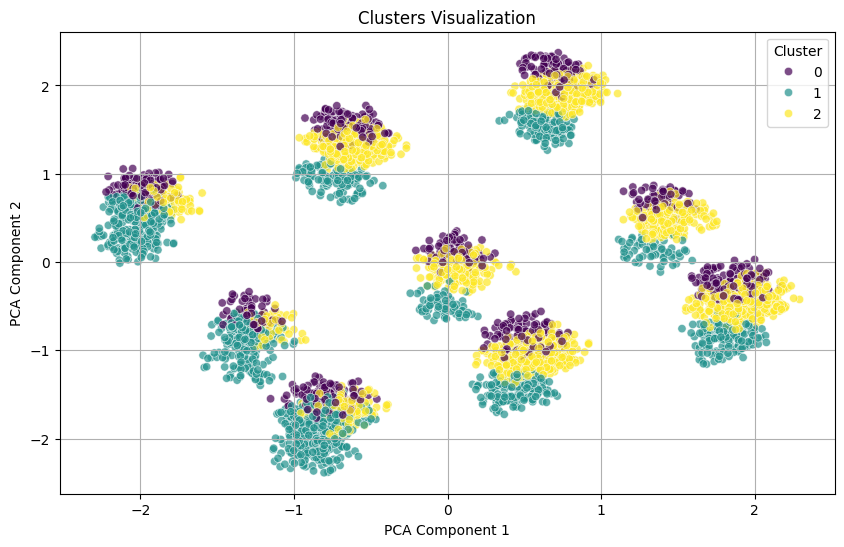

Linear Regression - Mean Squared Error: 69228408196.03, R^2 Score: -0.00, CV Score: -0.01


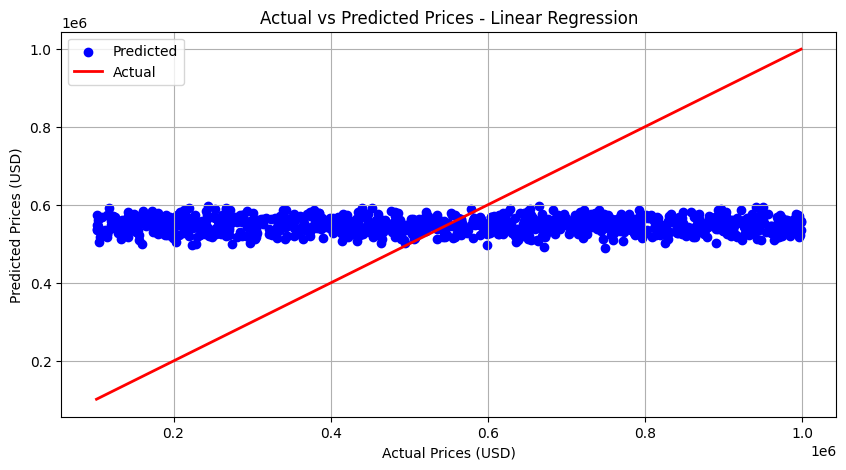

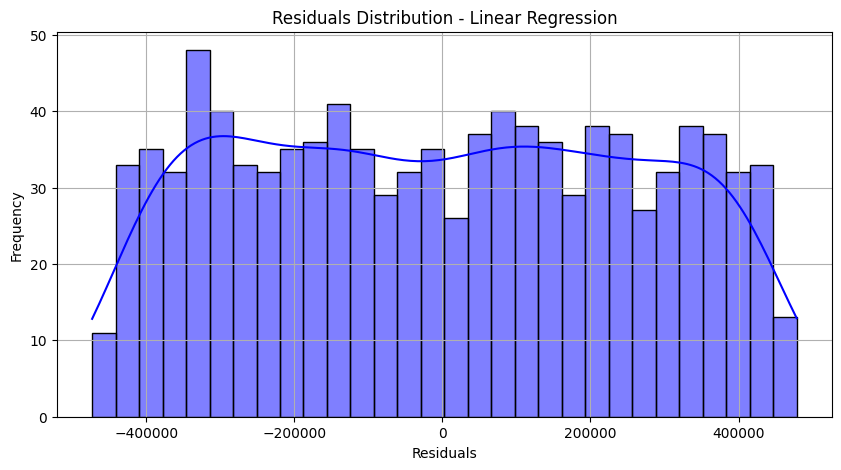

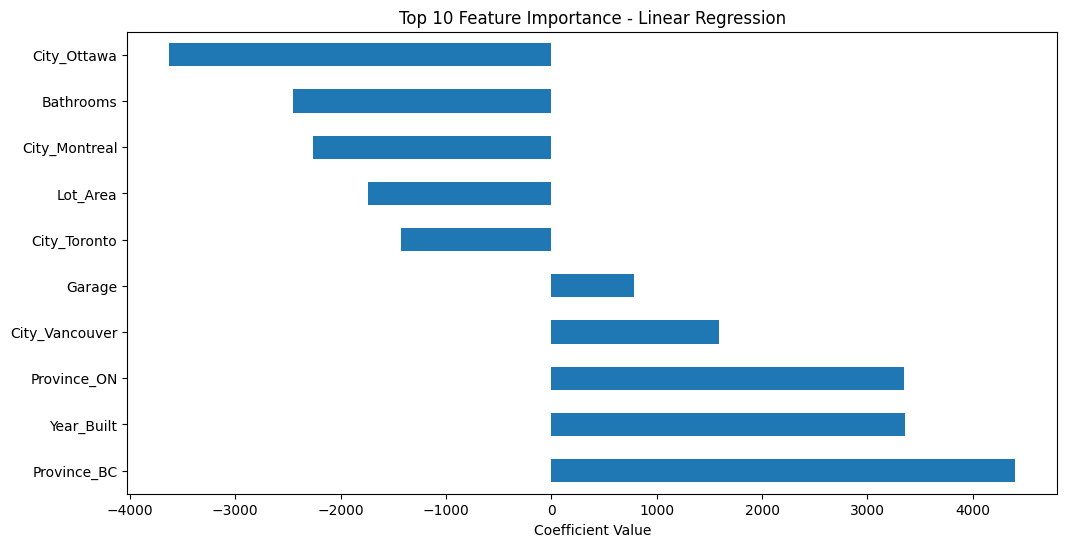

Ridge Regression - Mean Squared Error: 69228217439.37, R^2 Score: -0.00, CV Score: -0.01


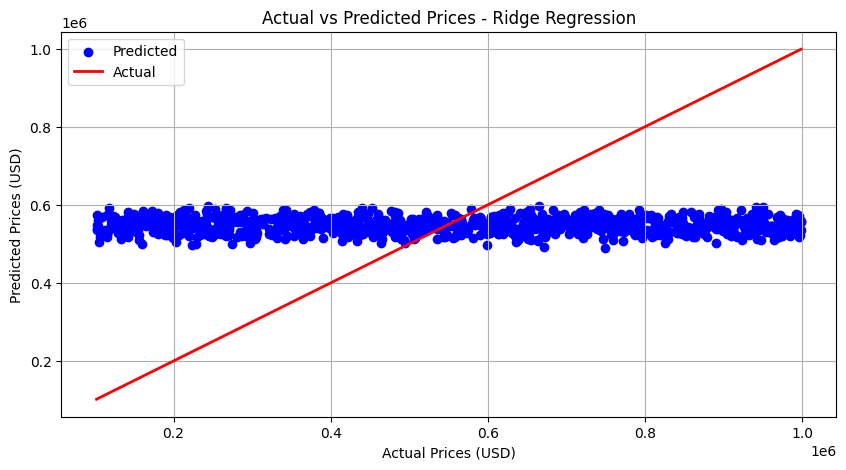

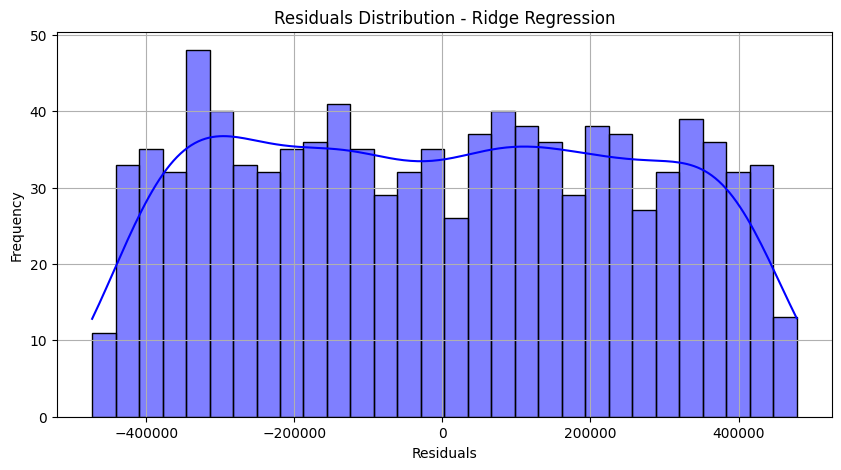

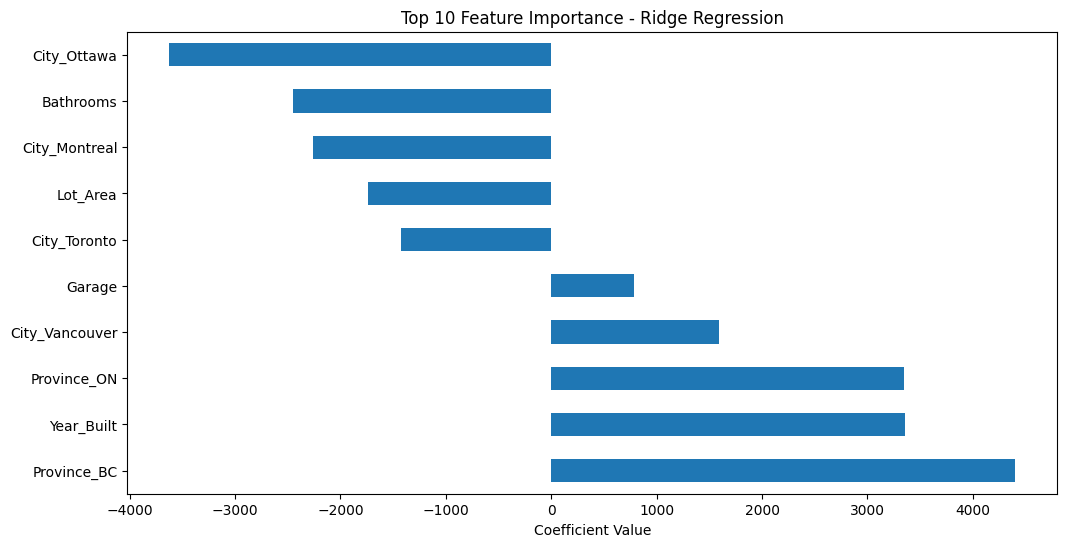

Lasso Regression - Mean Squared Error: 69228393813.43, R^2 Score: -0.00, CV Score: -0.01


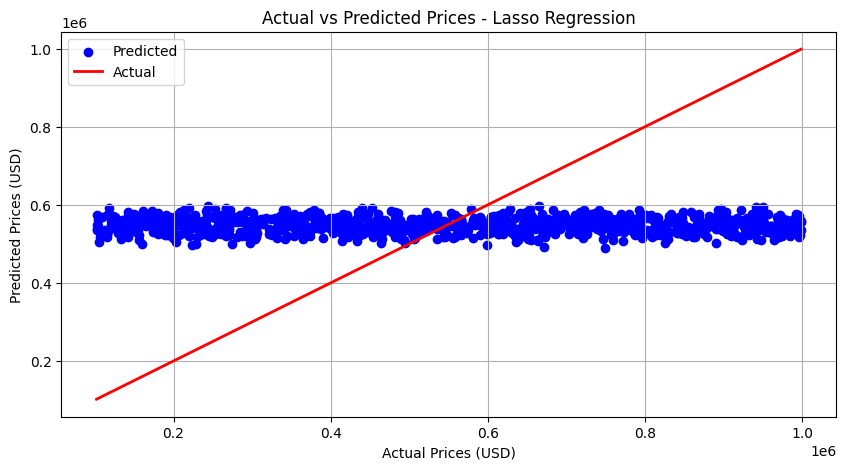

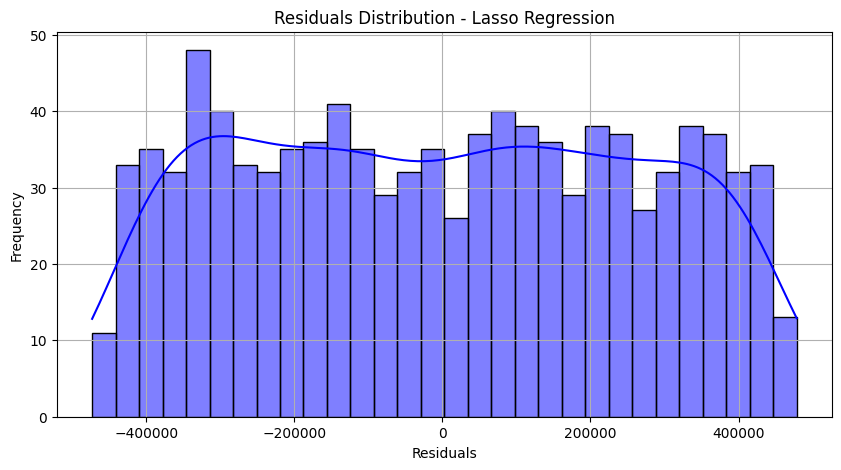

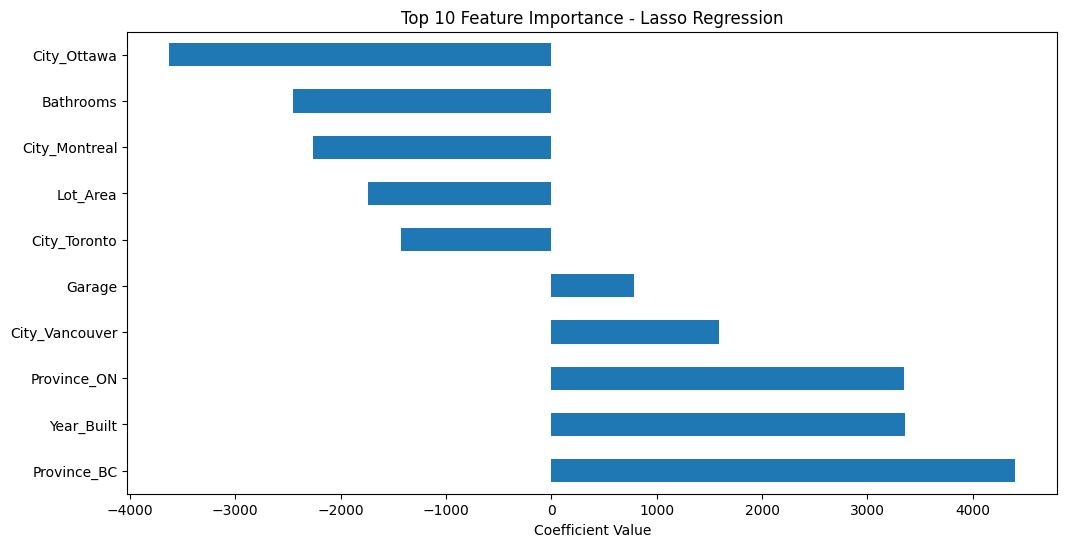

In [5]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from google.colab import drive

# Step 2: Load the Data
drive.mount('/content/drive')
df = pd.read_csv('/content/ca_real_estate.csv')

# Step 3: Data Preparation
print("Initial DataFrame shape:", df.shape)
print("Columns before cleaning:", df.columns.tolist())
print(df.head())

# Clean column names
df.columns = df.columns.str.strip()

# Check and print Price column information
if 'Price' in df.columns:
    print("Price column type:", df['Price'].dtype)

# Convert categorical features to numerical
categorical_columns = ['City', 'Province', 'Type']
missing_columns = [col for col in categorical_columns if col not in df.columns]
if missing_columns:
    print(f"Warning: Missing categorical columns: {missing_columns}")

# One-hot encoding for categorical features
df = pd.get_dummies(df, columns=[col for col in categorical_columns if col in df.columns], drop_first=True)

# Select features, dropping irrelevant columns
irrelevant_columns = ['zpid', 'Price', 'address', 'management_company_phone_number',
                     'listing_provided_by', 'hoa_details', 'financial',
                     'interior_full', 'property', 'construction',
                     'tag', 'contingent_listing_type']
features = df.drop(columns=irrelevant_columns, errors='ignore')

# Handle missing values by filling them with zeros
features.fillna(0, inplace=True)

# Target variable
target = df['Price'] if 'Price' in df.columns else None

# Ensure features are numeric and drop rows with NaN
features = features.apply(pd.to_numeric, errors='coerce').dropna()

# Align target with features
if target is not None:
    target = target.loc[features.index]

# Step 4: Clustering
if not features.empty:
    # Standardize features for clustering
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Determine optimal number of clusters using Elbow method
    inertia = []
    K = range(1, 11)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features_scaled)
        inertia.append(kmeans.inertia_)

    # Plot the Elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(K, inertia, marker='o')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.grid()
    plt.show()

    # Fit KMeans with chosen number of clusters (e.g., 3)
    optimal_k = 3  # Adjust based on Elbow plot
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df['Cluster'] = kmeans.fit_predict(features_scaled)

    # Visualize clusters using PCA
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_scaled)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=df['Cluster'], palette='viridis', alpha=0.7)
    plt.title('Clusters Visualization')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.grid()
    plt.show()

# Step 5: Train-Test Split
if not features.empty and target is not None and not target.empty:
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Step 6: Feature Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Step 7: Train the Models (Using Ridge and Lasso for comparison)
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1)
    }

    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)

        # Step 8: Make Predictions
        y_pred = model.predict(X_test_scaled)

        # Evaluate the Model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Cross-validation scores
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
        print(f'{model_name} - Mean Squared Error: {mse:.2f}, R^2 Score: {r2:.2f}, CV Score: {cv_scores.mean():.2f}')

        # Step 9: Visualization
        plt.figure(figsize=(10, 5))
        plt.scatter(y_test, y_pred, color='blue', label='Predicted')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Actual')
        plt.title(f'Actual vs Predicted Prices - {model_name}')
        plt.xlabel('Actual Prices (USD)')
        plt.ylabel('Predicted Prices (USD)')
        plt.grid()
        plt.legend()
        plt.show()

        # Additional Visualization: Residuals
        plt.figure(figsize=(10, 5))
        residuals = y_test - y_pred
        sns.histplot(residuals, bins=30, kde=True, color='blue')
        plt.title(f'Residuals Distribution - {model_name}')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.grid()
        plt.show()

        # Feature Importance (only for linear models)
        if hasattr(model, 'coef_'):
            plt.figure(figsize=(12, 6))
            feature_importance = pd.Series(model.coef_, index=X_train.columns)
            feature_importance.nlargest(10).plot(kind='barh')
            plt.title(f'Top 10 Feature Importance - {model_name}')
            plt.xlabel('Coefficient Value')
            plt.show()
else:
    print("No valid data available for training.")
